# **프로젝트 :  Transformer로 한영번역기 만들기**
트랜스포머를 이용해 한영번역기를 만들어보겠습니다.

먼저 필요한 라이브러리들을 불러와봅시다.
# **Step1. Import Necessary Libraries** 

In [ ]:
!pip install tensorflow==2.6.0

In [ ]:
!pip install keras==2.6.0

In [ ]:
# 나눔폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# sentencepiece 설치
!pip install sentencepiece

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
plt.rc('font', family='NanumBarunGothic')

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_notebook
import sentencepiece as spm
import re
import time
import seaborn

# **Step2.Import Data**

데이터는 다음 경로에서 한영 병렬 말뭉치를 다운받습니다 : https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

파일을 불러오고 5개의 문장을 출력해주는 함수를 정의해주겠습니다.

In [6]:
path_to_file = '/content/drive/MyDrive/GoingDeeper_Data/GD5/korean-english-park.train/'

def load_data(filename):
    with open(path_to_file + '{}'.format(filename), 'r') as f:
        raw = f.read().splitlines()

    print("data size:", len(raw))
    print("examples:")
    for s in raw[:5]:
        print(">>", s)

    return raw 

위에서 정의한 함수로 한국어 말뭉치와 영어 말뭉치를 불러오겠습니다.

In [7]:
# korean corpus
raw_kor = load_data("korean-english-park.train.ko")

data size: 94123
examples:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
>> 그러나 이것은 또한 책상도 필요로 하지 않는다.
>> 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
>> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.


In [8]:
# english corpus
raw_eng = load_data("korean-english-park.train.en")

data size: 94123
examples:
>> Much of personal computing is about "can you top this?"
>> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
>> Like all optical mice, But it also doesn't need a desk.
>> uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.
>> Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.


# **Step3. Preprocessing Data**
## 1.중복치제거
중복을 제거하는 함수를 정의합니다.

In [9]:
# 중복치제거 함수
def clean_corpus(ko, en):
    raw = zip(ko, en)
    set_raw = set(raw)
    corpus_kor, corpus_eng = zip(*set_raw)
    print('중복제거된후 data길이:', len(set_raw))

    return corpus_kor, corpus_eng

In [10]:
# 함수적용
cleaned_corpus_kor, cleaned_corpus_eng = clean_corpus(raw_kor, raw_eng)

중복제거된후 data길이: 78968


## 2.데이터정제
다음 조건을 만족하는 정제함수를 정의합니다.
- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다.
- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [11]:
# 데이터정제 함수
def preprocessing(sentence):
    # change to lowercase
    sentence = sentence.lower().strip()
    # remove all except for english,korean,number and punctuation  
    sentnece = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)
    # 구두점 양옆에 공백추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 문장 앞뒤의 공백을 제거
    sentence = sentence.strip()

    return sentence

In [12]:
# 정제함수 적용후 리스트에 저장
kor_corpus = []
eng_corpus = []

for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
    kor_corpus.append(preprocessing(kor))
    eng_corpus.append(preprocessing(eng))

## 3.토큰화
정제된 말뭉치를 가지고 토큰화를 진행합니다. 토큰화에는 Sentencepiece를 활용합니다.

**SentencePiece**는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다.

이를 위해 아래의 조건을 만족하는 generate_tokenizer()함수를 정의합니다.
- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
- 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.

In [13]:
def generate_tokenizer(corpus, vocab_size, lang):
    
    # 주소지정
    temp_file = '/content/drive/MyDrive/GoingDeeper_Data/GD5/korean-english-park.train.{}.temp'.format(lang)
    
    # 말뭉치를 해당 주소에 씀
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')

    # Sentencepiece Train
    spm.SentencePieceTrainer.Train(
        '--input={} --model_prefix={}_spm_bpe_20k --model_type=bpe --vocab_size={}'.format(temp_file, lang, vocab_size)
    )

    # 토크나이저 생성
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('{}_spm_bpe_20k.model'.format(lang))

    return tokenizer

# 한국어, 영어 토크나이저 생성
ko_tokenizer = generate_tokenizer(kor_corpus, 20000, 'ko')
en_tokenizer = generate_tokenizer(eng_corpus, 20000, 'en')
# 타겟문장의 양끝에 시작토큰과 끝토큰을 포함시킴
en_tokenizer.set_encode_extra_options("bos:eos")

True

한국어와 영어의 단어장 크기를 확인해봅시다.

In [14]:
with open("ko_spm_bpe_20k.vocab", 'r') as f:
        vocab = f.readlines()

print("한국어 단어장 크기: ",len(vocab))

with open("en_spm_bpe_20k.vocab", 'r') as f:
        vocab = f.readlines()

print("영어 단어장 크기: ",len(vocab))

한국어 단어장 크기:  20000
영어 단어장 크기:  20000


In [15]:
# 토큰화를 하고 길이가 50미만인 문장만 리스트에 담음
src_corpus = []
tgt_corpus = []

for ko, en in tqdm(zip(kor_corpus, eng_corpus)):
    seq_kor = ko_tokenizer.EncodeAsIds(ko)
    if len(seq_kor) < 50:
        seq_eng = en_tokenizer.EncodeAsIds(en)
        src_corpus.append(seq_kor)
        tgt_corpus.append(seq_eng)

78968it [00:10, 7838.21it/s]


## 4.패딩


In [16]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = pad_sequences(src_corpus, padding='post')
dec_train = pad_sequences(tgt_corpus, padding='post')

패딩이 잘 됐는지 확인해봅시다.

In [17]:
enc_train[:2]

array([[  542,   566,  1896,  6122, 10624, 17030, 18716,  1642,   202,
         3079, 11079,  2592, 16014, 18757,  1599,   235, 12341, 17442,
         1519, 18711, 17001,  5261,   417,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  162, 19014, 19612, 19067,   356,  5027,  3624,  6945,    20,
        18827, 18947, 18780, 18722,   175,   439,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]], dtype=int32)

In [18]:
dec_train[:2]

array([[    1,  3236,   147,  2773,    32,  1297,   289, 15154,    32,
         1626,   639,  6021,  6038,    36,     8,  1934,  2303,    67,
        19965,  5984,     8, 11084,    36,   237,  2693,    12,     2,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [    1,  1002, 19834,    18, 11093,  4566, 19971, 19952,  3703,
           95,  1079, 19802,    33,    12,     2,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     

# **Step4. 내부 모듈 구현하기**
트랜스포머를 완성하는 데에 필요한 모듈들을 하나하나 만든후, 조립하여 완성하는 방식으로 진행하겠습니다.
## 1.Positional Encoding
해당 값을 계산하는 수식은 다음과 같습니다.
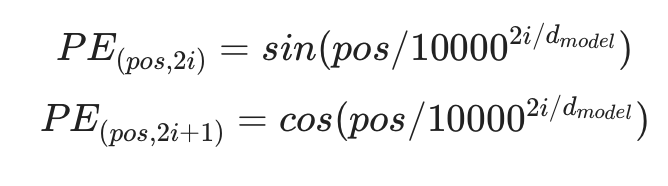

In [19]:
def positional_encoding(pos, d_model):

    # pos/10000^(i/d_model)생성
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)
    
    # d_model열까지 cal_angle()함수값 계산
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    # 각 행(문장)마다 get_posi_angle_vec()함수 적용해서 넘파이 배열로 저장 
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    # 짝수 열(2i)에 해당하는 값만 sin()함수에 넣어서 테이블에 저장
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # 홀수 열(2i+1)에 해당하는 값만 cos()함수에 넣어서 테이블에 저장
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    # 포지서널 인코딩 값이 계산된 행렬
    return sinusoid_table

## 2.Multi-Head Attention
Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성됩니다.
- split_heads() : 임베딩된 입력을 Head수로 분할
- scaled_dot_product_attention() : 분할된 입력으로부터 Attention값을 구함
- combine_heads() : 연산이 종료되고 분할된 Head를 다시 하나로 결합시켜줌

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // self.num_heads

        # Head로 쪼갠 Embedding들끼리 유사한 특성을 가진다는 보장이 없기 때문에 앞단에 Linear 레이어를 추가해 주는 겁니다.
        # Linear 레이어는 데이터를 특정 분포로 매핑 시키는 역할을 해주기 때문에, 설령 단어들의 분포가 제각각이더라도, 
        # Linear 레이어는 Multi-Head Attention이 잘 동작할 수 있는 적합한 공간으로 Embedding을 매핑합니다.
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        # 비슷한 이유로 각각의 Head가 Attention 한 값이 균일한 분포를 가질 거란 보장이 없습니다. 
        # 따라서 모든 Attention 값을 합쳐준 후, 최종적으로 Linear 레이어를 거치며 비로소 Multi-Head Attention이 마무리가 됩니다.
        self.linear = tf.keras.layers.Dense(d_model)

    # 임베딩벡터를 헤드수로 분할하는 함수
    # x : [batch x length x emb]
    # return : [batch x length x heads x self.depth]
    def split_heads(self, x):
        # 입력데이터 개수
        batch_size = x.shape[0]
        # 입력데이터 reshape
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # 입력데이터 차원의 1번과 2번인덱스 자리변경
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    # 분할된 입력으로부터 어텐션 값을 구하는 함수
    def scaled_dot_product_attention(self, Q, K, V, mask):
        # K의 길이를 실수형태로 d_k에 저장
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)

        # 1. Attention Weights 값 구하기 -> attentions
        # 2. Attention 값을 V에 곱하기 -> out
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        return out, attentions

    # 분할된 Head를 다시 하나로 결합시켜주는 함수
    # x: [ batch x length x heads x self.depth ]
    # return: [ batch x length x emb ]
    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
    
    def call(self, Q, K, V, mask):

        # Step1 : Linear_in(Q, K, V) -> WQ, WK, WV
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        # Step2 : Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        # Step3 : scaled Dot Product Attention
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        # Step4 : combine Heads
        out = self.combine_heads(out)
        
        # Step5 : Linear_out
        out = self.linear(out)

        return out, attention_weights

## 3.Position-wise Feed_Forward Network
[ batch x length x d_model ]의 입력을 받아 w_1이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 w_2를 통해 512차원으로 되돌리는 과정입니다. 논문에서는 d_ff=2048, d_model=512입니다.

In [21]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)

        return out

## 4. Layer Normalization
추가적으로 Layer Normalization이 있습니다.

Normalization의 목표는 값 범위의 차이를 왜곡시키지 않고 데이터 세트를 공통 스케일로 변경하는 것입니다. 데이터 처리에 있어 각 특성의 스케일을 조정한다는 의미로, feature scaling 이라고도 불립니다. 흔히 스케일 조정 중 Min-Max Scaler 의 의미로 사용되기도 합니다.

그리고 Normalization Layer의 위치에 대한 논의입니다. 실제 논문에서는 [Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN)으로 표현되어 있지만 정작 Official 구현인 구글의 Tensor2Tensor 에서는 [Input] - [Norm] - [Module] - [Residual] 방식을 사용했습니다.

트랜스포머의 Layer Normalization의 위치에 대한 논의를 다룬 On Layer Normalization in the Transformer Architecture이라는 제목의 논문이 2020년 초반에 발표되었습니다. 이 논문에서는 모듈 앞에 Normalization Layer를 두는 pre-LN 방식이 유리하다고 설명하고 있습니다.

## 5. Residual Connection(Skip Connection)
Skip Connection은 각각의 Layer들이 기존에 학습한 정보를 보존하고, 작은 정보들을 추가적으로 학습하도록 합니다.(=각 레이어가 배워야 할 정보량을 축소)

깊은 레이어를 갖는 네트워크일수록 Optimize하기 어렵기 때문에, 얕은 네트워크가 더 좋은 성능을 보입니다. 때문에 skip connection을 이용해 네트워크를 더 깊게 쌓을 수 있습니다. 



## 6.Weight Sharing
Weight Sharing은 모델의 일부 레이어가 동일사이즈의 Weight를 가질 때 하나의 Weight를 두 개 이상의 레이어가 동시에 사용하도록 하는 것인데입니다.

이는 비효율적으로 보일 수 있습니다. 각 레이어들은 그만한 역할이 있을것인데, 둘을 엮어버리면 이도 저도 아닐 것 같은 느낌이 들죠. 하지만 Weight Sharing은 학습할 파라미터 수가 감소하기 때문에 학습에 더 유리하며 자체적으로 Regularization 되는 효과도 있습니다.

트랜스포머에서는 Decoder의 Embedding 레이어와 출력층 Linear 레이어의 Weight를 공유하는 방식을 사용했습니다. 논문상에서는 소스 Embedding과 타겟 Embedding도 공유했지만 이는 언어의 유사성에 따라서 선택적으로 사용합니다.

또한 출력층 Linear 레이어와 Embedding 레이어의 Feature 분포가 다르므로 Embedding 된 값에 
sqrt(d_model)을 곱해줍니다. 이는 분포를 맞춰줌과 동시에 Positional Encoding이 Embedding 값에 큰 영향을 미치는 것을 방지해 줍니다.

# **Step5. 모듈 조립하기**
위의 모듈들을 가지고 트랜스포머의 인코더 한층과 디코더 한층을 각각 완성할 수 있습니다. 

마치 텐서플로우의 Dense레이어를 사용하듯이 EncoderLayer, DecoderLayer를 쓸 수 있게하려면 tf.keras.layers.Layer클래스를 상속받아 레이어 클래스로 정의해주면됩니다. 


## 1. Encoder 레이어 구현하기

In [22]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        # Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual

        # Position-Wise Fedd Forward Network
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, enc_attn

## 2. Decoder 레이어 구현하기
디코더에서는 인코더와 달리 두번의 어텐션이 진행됩니다.

In [23]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):
        # Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        # Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

이렇게 인코더층과 디코더층을 모두 정의했습니다. 이를 조립해서 인코더와 디코더 클래스를 정의합니다.
## 3. Encoder 구현하기

In [24]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        # 층수 설정
        self.n_layers = n_layers
        # 설정된 층수를 반복문으로 인코더계층 리스트생성
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]

    def call(self, x, mask):
        out = x
        enc_attns = list()
        
        # 각 계층별로 어텐션 가중치(확률분포)를 리스트에 저장 
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

## 4. Decoder 구현하기

In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]

    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()

        # 각 계층별 두개의 어텐션 가중치(확률분포)를 각 리스트에 저장
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

# **Step6. Transformer 완성하기**
정의된 인코더와 디코더를 가지고 최종적으로 트랜스포머를 완성합니다. 그리고 해당 Transformer클래스는 다음 조건을 만족합니다.
- Shared변수를 매개변수로 받아 True일 경우, Decoder Embedding과 출력층 Linear의 가중치를 공유하도록 합니다.
- positional_encoding의 반환값 형태는 [ Length x d_model ]인데, 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ]이라서 연산이 불가능하기때문에, 연산이 가능하도록 수정합니다.

In [26]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        # 1.Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        # 2.Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        
        # 3.Dropout 정의
        self.dropout = tf.keras.layers.Dropout(dropout)

        # 4.인코더/디코더 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        # 5.Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        # 6.Shared Weights
        self.shared = shared
        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))
    
    def embedding(self, emb, x):
        # 문장길이 저장
        seq_len = x.shape[1]
        
        # 임베딩벡터 저장
        out = emb(x)
        
        # 1.가중치를 공유하는 두레이어의 feature분포가 다르기때문에, sqrt(d_model)을 곱해 분포를 맞춰주는과정
        # 2.포지셔널 인코딩이 임베딩벡터에 큰 영향을 끼치는것을 방지
        if self.shared: out *= tf.math.sqrt(self.d_model)

        # 포지셔널인코딩과 임베딩벡터의 연산을 위해 차원을 변경시켜줌
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]

        # 드롭아웃적용
        out = self.dropout(out)

        return out

    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):

        # 1.Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        # 2.Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        # 3.Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        # 4.Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

# **Step7. 외부모듈 구현하기**
이제 모델 외적인 부분을 정의해 주도록 하겠습니다.
## 1.Masking

In [27]:
# 패딩 마스킹 : 문장에서 패딩인 부분을 전부 찾아주는 함수
def generate_padding_mask(seq):
    # 문장에서 0인것을 전부 True, 아니면 False로 바꿔주고 이들을 전부 1과 0으로 표현
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # 문장형태에서 1과 2번인덱스에 차원추가
    return seq[:, tf.newaxis, tf.newaxis, :]

# 룩 어헤드 마스킹 : 마스크를 해줄요소가 전부1이고 아니면0인 행렬 생성
def generate_causality_mask(src_len, tgt_len):
    # np.eye(a, b) : a행b열의 단위행렬을 만들어줌
    # np.cumsum(a, axis=0) : 행을 그 다음행에 중첩하면서 더해줌, shape은 변하지않음
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

# 패딩 마스크와 룩 어헤드 마스크를 동시에 적용하는 함수
def generate_masks(src, tgt):
    # 입력과 타깃문장 패딩 마스킹 생성
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    # 인코더-디코더 어텐션 룩어헤드마스킹 생성
    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1]) 
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    # 디코더 어텐션 룩어헤드마스킹 생성
    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

## 2. Learning Rate Schedular
트랜스포머를 훈련하는 데에는 Adam Optimizer를 사용했는데, 특이한 점은 Learning Rate를 수식에 따라 변화시키며 사용했다는 것입니다. warmup_steps까지는 lrate가 선형적으로 증가 하고, 이후에는 step_num에 비례해 점차 감소하는 모양새 를 보이게 됩니다.

이와 같은 Learning Rate를 사용하면 초반 학습이 잘되지 않은 상태에서의 학습 효율이 늘어나고, 어느 정도 학습이 된 후반에는 디테일한 튜닝을 통해 Global Minimum을 찾아가는 효과가 나게 됩니다. 학습의 초반과 후반은 warmup_steps 값에 따라 결정되죠.

Tensorflow 상에서 잘 구동될 수 있도록 LearningRateSchedule클래스를 상속받아 구현해봅시다.

In [28]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    # 학습률 스케줄러 수식에 해당하는 전개과정
    # 아래 과정으로 생선된 값을 learning rate로 사용
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

# **Step8. 훈련하기**
앞서 모델에 관한것을 모두 정의했습니다. 이제 훈련에 필요한것들을 정의하고, 훈련을 시켜주겠습니다.
## 1.트랜스포머 선언

In [29]:
transformer = Transformer(n_layers=4,
                          d_model=512,
                          n_heads=8,
                          d_ff=2048,
                          src_vocab_size=20000,
                          tgt_vocab_size=20000,
                          pos_len=len(enc_train),
                          dropout=0.2,
                          shared=True)

## 2. Learning Rate Scheduler 와 Adam Optimizer 선언
논문에서 사용한 것과 동일하게 설정합니다.

In [30]:
learning_rate = LearningRateScheduler(d_model=512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

## 3. Loss함수 정의

In [31]:
# logits : 텐서플로우에서 소프트맥스함수를 거치기전의 데이터
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # 마스킹되지 않은 입력의 개수로 Scaling하는 과정
    # 결론적으로 마스킹된부분의 loss는 계산하지않음
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    # tf.reduce_sum() : 입력행렬내에서 설정된 axis를 기준으로 sum연산이 수행됨, 차원감소   
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## 4. train_step함수 정의
입력데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게합니다.

In [32]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    # 시작토큰 제외
    gold = tgt[:, 1:]

    # 마스크행렬 생성
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])
        # tape.gradient() : 매스텝 학습이 진행될때마다 발생하는 그래디언트 추출
        gradients = tape.gradient(loss, model.trainable_variables)
    # 최종적으로 optimizer.apply_gradients()가 사용됩니다.
    # gradient가 업데이트 해야할 파라미터 지정
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

## 5. Attention 시각화함수 정의
: 입력문장과 번역문장을 넣어주면, 모델이 어디에 집중을했는지 heatmap으로 시각화해줍니다.

In [33]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, x='auto', y='auto'):
        seaborn.heatmap(data,
                        square=True,
                        vmin=0.0, vmax=1.0,
                        cbar=False,
                        xticklabels=x,
                        yticklabels=y)
    
    # 디코더의 어텐션가중치를 시각화
    for layer in range(0, 4, 1):
        plt.figure(figsize=(20,10))
        print('Decoder Src Layer', layer + 1)
        draw(dec_enc_attns[layer][0, layer, :len(tgt), :len(src)], src, tgt)
        plt.show()

## 6. 번역생성함수 정의
: 문장을 넣어주면 번역된 문장을 반환합니다.

In [34]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    # 문장 전처리 
    sentence = preprocessing(sentence)
    # 문장을 단어단위로 분리 
    pieces = src_tokenizer.encode_as_pieces(sentence)
    # 분리된 단어들을 id로 변환
    tokens = src_tokenizer.encode_as_ids(sentence)
    # 토큰화된 문장을 패딩
    _input = pad_sequences([tokens],
                           maxlen=enc_train.shape[-1],
                           padding='post')
    
    ids = []
    # bos_id() : bos토큰의 id를 출력
    # 시작토큰id를 저장
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)

    for i in range(dec_train.shape[-1]):
        # 마스크 생성
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        # 모델 예측값 출력
        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        # argmax() : 지정된 축을따라 가장 높은값의 인덱스를 출력
        # 가장 높은 확률의 단어id를 저장
        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        # end토큰이 나올경우 시퀀스를 디코딩하고 반환
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns
        
        # 단어id를 리스트에 추가
        ids.append(predicted_id)
        # 예측된 단어id를 output에 붙여줌
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    # 지금까지 저장된 정수시퀀스를 디코딩해서 저장
    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

## 7. 번역생성 및 Attention 시각화결합함수 정의

In [35]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    # 번역문 저장
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # plot_attention변수를 True로 주면 Attention map을 시각화
    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

## 8. Train
: 모델학습을 시작합니다

In [36]:
BATCH_SIZE = 64
EPOCHS = 20

examples = ["오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."]

for epoch in range(EPOCHS):
    total_loss = 0

    # 배치 시작 인덱스들을 리스트로 저장
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    # 인덱스를 섞어줌
    np.random.shuffle(idx_list)
    # tqdm iterator생성
    t = tqdm_notebook(idx_list)

    # 해당 epoch에서의 배치별 loss계산
    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                   dec_train[idx:idx+BATCH_SIZE],
                   transformer,
                   optimizer)
        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    # 해당 epoch에서 번역문 출력
    for ex in examples:
        translate(ex, transformer, ko_tokenizer, en_tokenizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential presidential presidential presidential presidential presidential presidential presidential presidential presidential presidential presidential presidential presidential presidential presidential presidential presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: the man was found in a man .
Input: 커피는 필요 없다.
Predicted translation: they'll get to get .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the shiite wounded killed in southern eastern soldiers .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is expected to be a presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city's most of the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is not only .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the attack killed three people .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is one of obama supporters .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of cities is in cities .
Input: 커피는 필요 없다.
Predicted translation: coffee is not available .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the murder of seven people were killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: cities
Input: 커피는 필요 없다.
Predicted translation: the no .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama , obama is a great senator .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city's urban areas .
Input: 커피는 필요 없다.
Predicted translation: the coffee is nothing new .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first choice .
Input: 시민들은 도시 속에 산다.
Predicted translation: city's historic cities .
Input: 커피는 필요 없다.
Predicted translation: the no amount of the coffee is not a member of the mission .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven other seven buildings are killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president-elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: there's been increasing demonstrations in the city .
Input: 커피는 필요 없다.
Predicted translation: the no . 2 . 2 . bun called for the model . there:
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven-way high-ranking iraqi officials were retaced by the seven-wayway seven .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the second-largest contribim .
Input: 시민들은 도시 속에 산다.
Predicted translation: whatever city people's reputation 
Input: 커피는 필요 없다.
Predicted translation: never stop at the airport .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven sunni dead included a seven-month paddle is the seven-way strain of the seven .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is on a joint message from obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city's reputation on the
Input: 커피는 필요 없다.
Predicted translation: "there is no sign that no need for coffee , " the embassy said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven were killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is on his website .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city commissioner for cities promise
Input: 커피는 필요 없다.
Predicted translation: no . 1 coffeeun ?
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other fatalities are also .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the second president .
Input: 시민들은 도시 속에 산다.
Predicted translation: named cities of cities
Input: 커피는 필요 없다.
Predicted translation: for example , the overnight alcohol remains a cup .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven were killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: named cities of residents in cities .
Input: 커피는 필요 없다.
Predicted translation: no . 1 continue .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first obama administration .
Input: 시민들은 도시 속에 산다.
Predicted translation: named cities in cities .
Input: 커피는 필요 없다.
Predicted translation: no changes in the united states .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are also unable to get a picture of the seven other dead .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president for the illinois presidential office .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of cities
Input: 커피는 필요 없다.
Predicted translation: no . 2 coffeeun continue for the regulations and don plants .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the victims were killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is among the voters .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city's residents in cities urged residents in large parts of the city .
Input: 커피는 필요 없다.
Predicted translation: no . 1 in the united states .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other seven were killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is moving to illinois , where obama is the illinois presidential office .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city's center cun residents in cities , are generally criding .
Input: 커피는 필요 없다.
Predicted translation: no: buy coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the mps were also killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the economy .
Input: 시민들은 도시 속에 산다.
Predicted translation: named global city audience residents .
Input: 커피는 필요 없다.
Predicted translation: no . buy coffee is set for meals .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the victims were killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama , on the obama side of his presidential campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: there's something new .
Input: 커피는 필요 없다.
Predicted translation: no: nothing . . . )
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven iraqi refugees also died in the 7 .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is turning down across the obama administration .
Input: 시민들은 도시 속에 산다.
Predicted translation: named cities in cities .
Input: 커피는 필요 없다.
Predicted translation: no . 1 guide .maliki's no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven militants were killed by the seven interior ministry .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama , who visited the presidential nomination .
Input: 시민들은 도시 속에 산다.
Predicted translation: named c visitor to cities .
Input: 커피는 필요 없다.
Predicted translation: no: it is for you .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


# **Step9. Evaluation**

Input: 오늘 하루 고생하셨습니다.
Predicted translation: he's head of the overall head .
Decoder Src Layer 1


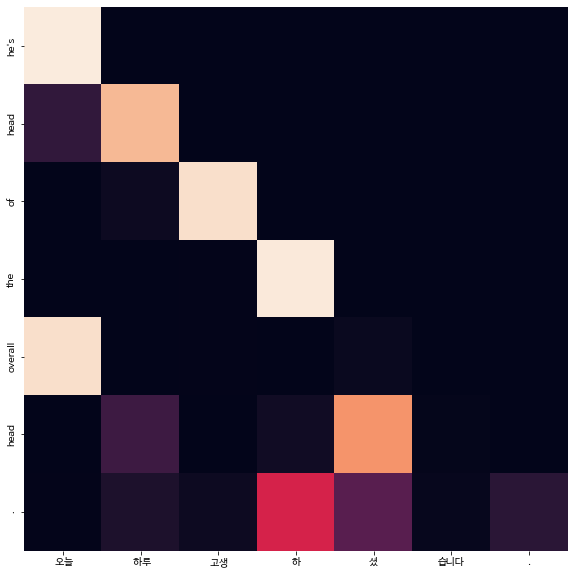

Decoder Src Layer 2


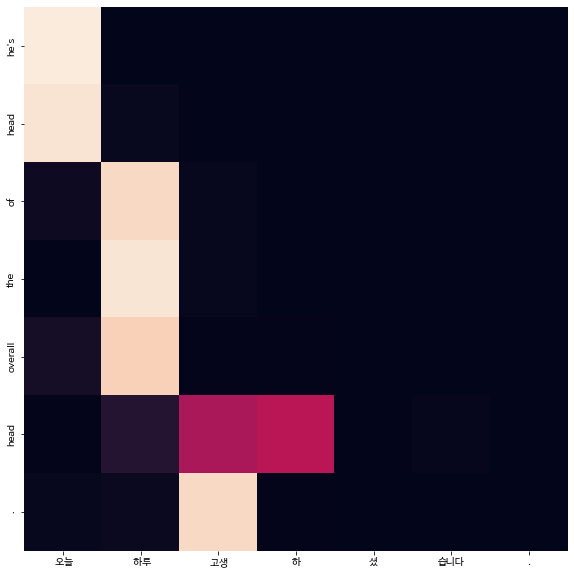

Decoder Src Layer 3


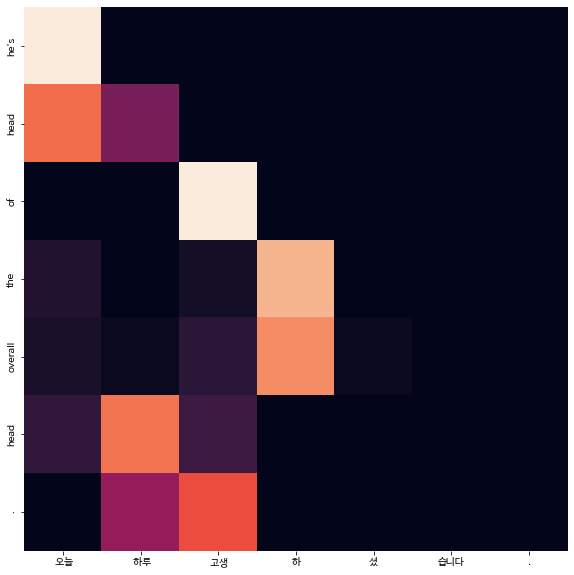

Decoder Src Layer 4


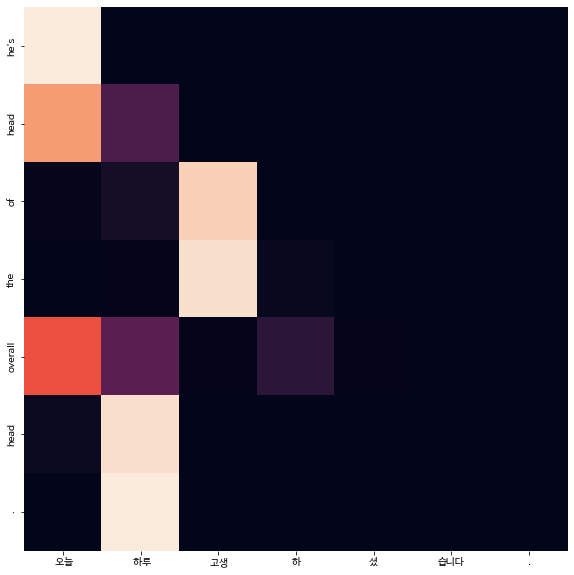

In [39]:
translate("오늘 하루 고생하셨습니다.", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

# **회고**
- 지금까지 했었던 노드중에서 가장많은 시간을 쏟은 노드이다… 그만큼 트랜스포머를 이해하기가 어려웠다. 하지만 앞으로 배울 모델들 그리고 최신모델들은 트랜스포머를 기반으로 만들어진것이기때문에, 트랜스포머를 이해하지못하면 앞으로가 매우 힘들것같아 최대한 이해해보려했다. 개념적으로든 코드로든
- Seq2seq보다는 번역을 나름 잘하는것같다. 해당 문장에 있는 핵심 단어들이 포함되서 번역이되긴하지만, 그래도 제대로된 번역이라고 보기는 어려운것같다.
